## Figure 5 for Acoustic Features paper.  Performance of encoder and tuning curves

The data used here is generated by running the acousticEncoder models on all the pre-processed data as explained in the figure5.ipnb document.  The acousticEncoder runs all the encoder models of interest and is also a wrapper to run through all the data set.  The code is found in testCode/acousticEncoder.py (https://github.com/ftheunissen/testCode) 
An aggregate pandas data frame that has the results of all these encoders is then generated by
testCode/acousticEncoderAgg.py.
This code starts by reading this aggregate results data frame.

In [8]:
# Dependencies
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Location of pandas data frame.  Change if you stored it somewhere else.
agg_file = '/Users/frederictheunissen/Documents/Data/mschachter/aggregate/encoder_all.pkl'


In [2]:
# More Global Parameters
exp_names = ['YelBlu6903F', 'GreBlu9508M', 'WhiWhi4522M' ]   # The 3 birds that are part of this data set
decomps = ['spike_rate', 'full_psds']   # The two types of neural representations: the spike rate and the power spectrum decomposition of LFPs

In [3]:
# Read the summary data file
resultsPD = pd.read_pickle(agg_file)

In [4]:
resultsPD

,W,alpha,b,features,group,name,neural feat,predict,r2,r2_std,experiment,site,decomp
0,"[-0.00633447747250839, 0.0009748100639300066, ...",8.685114,-0.076329,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,0,"[0.0997924720033009, 0.09179340833664175, 0.18...",7.754766e-03,7.916633e-03,WhiWhi4522M,Site2_Call2_L,spike_rate
1,"[-0.0052064930135752256, 0.0008244797599543173...",0.625055,0.149087,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,1,"[0.37738279307382316, -0.049875222951131476, -...",2.827130e-02,4.254014e-02,WhiWhi4522M,Site2_Call2_L,spike_rate
2,"[-1.20504013827781e-07, 2.4434889084032628e-08...",1000000.000000,-0.015365,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,2,"[-0.015363040846590239, -0.015362869424259382,...",-9.840499e-08,3.219802e-07,WhiWhi4522M,Site2_Call2_L,spike_rate
3,"[-0.0031837231725209327, 0.0005375826187942629...",26.826958,-0.055702,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,3,"[0.004136489043219102, 0.01427963274674568, 0....",2.342159e-03,3.896993e-03,WhiWhi4522M,Site2_Call2_L,spike_rate
4,"[3.214333565946781e-08, -7.032418923110923e-09...",1000000.000000,0.007862,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,4,"[0.00786182559984384, 0.007861906249447709, 0....",-2.563794e-08,6.334430e-08,WhiWhi4522M,Site2_Call2_L,spike_rate
5,"[-7.433115956459988e-08, 1.4654175294501057e-0...",1000000.000000,-0.010894,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,5,"[-0.010893421983436229, -0.010892729118763742,...",-3.767428e-08,2.318846e-07,WhiWhi4522M,Site2_Call2_L,spike_rate
6,"[-0.0033467700715376853, 0.000866543858731224,...",2.811769,-0.055366,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,6,"[0.10790132417226198, -0.013816990569991514, 0...",4.275185e-02,2.021497e-02,WhiWhi4522M,Site2_Call2_L,spike_rate
7,"[-1.208249176414905e-05, -1.5238638430255503e-...",2.811769,-0.006951,"[b'meanspect', b'stdspect', b'skewspect', b'ku...",0,Nested,6,"[-0.09001688587061304, -0.011504272777184753, ...",4.099815e-02,2.021488e-02,WhiWhi4522M,Site2_Call2_L,spike_rate
8,"[-0.002995694261636327, 0.0008071054086848917,...",1.930698,-0.148464,"[b'maxAmp', b'stdtime', b'loud', b'stdspect', ...",1,Nested,6,"[0.07164750640302445, -0.07291751283907535, -0...",3.693394e-02,2.222862e-02,WhiWhi4522M,Site2_Call2_L,spike_rate
9,"[-0.003315165902350455, 0.0008539975126299764,...",2.811769,-0.091882,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",2,Nested,6,"[0.11495854295408295, 0.0005357885969068665, 0...",4.412353e-02,2.074333e-02,WhiWhi4522M,Site2_Call2_L,spike_rate


In [12]:
# Select r2 for full model for each site and decomposition to make hitograms and bar plot

mfullSpike = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'spike_rate')] 
mfullLFPLow = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'full_psds') & (resultsPD['neural feat'] < 16)] 
mfullLFPMed = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'full_psds') & (resultsPD['neural feat'] < 32) & (resultsPD['neural feat'] >= 16)]
mfullLFPHigh = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'full_psds') & (resultsPD['neural feat'] >= 32)] 

### Make plot of full encoder model R2

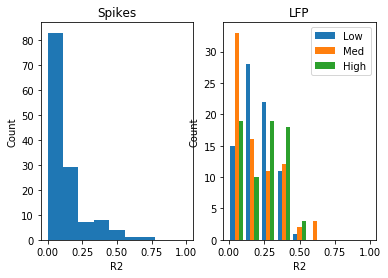

In [32]:
plt.figure()

# Histogram for spikes
plt.subplot(1,2,1)
plt.hist(mfullSpike['r2'], bins = np.linspace(0.0, 1.0, 10))
plt.xlabel('R2')
plt.ylabel('Count')
plt.title('Spikes')

# Histogram for LFS
plt.subplot(1,2,2)
plt.hist([mfullLFPLow['r2'].dropna(), mfullLFPMed['r2'].dropna(), mfullLFPHigh['r2'].dropna()],
         bins = np.linspace(0.0, 1.0, 10),  histtype = 'bar', stacked = False)
plt.xlabel('R2')
plt.ylabel('Count')
plt.title('LFP')
plt.legend(['Low', 'Med', 'High'])

In [21]:
mfullLFPHigh['r2'].min()

-4.153544288421074e-07

In [22]:
data = [mfullLFPLow['r2'], mfullLFPMed['r2'], mfullLFPHigh['r2']]

In [26]:
data[2].dropna()

432    -7.142243e-08
433     8.656792e-02
443     2.090130e-01
453     2.201258e-01
463     6.918645e-06
464    -2.420218e-08
465    -4.153544e-07
466     3.517801e-02
467     3.077224e-01
477     4.447861e-01
487     3.468885e-01
497     2.729123e-01
507     3.110745e-01
517     4.093210e-01
527     3.124314e-01
537     4.554723e-01
838     5.980895e-03
839    -8.079268e-08
840     1.502806e-03
850     1.430874e-05
851     1.028804e-03
861     5.899570e-03
862     8.440936e-03
863    -1.465679e-07
864     8.888223e-02
874     1.086083e-01
884    -5.148897e-08
885     6.167028e-02
895     8.721526e-02
905     1.212126e-03
            ...     
1796    1.691491e-02
1797    1.354813e-02
1798   -3.435974e-07
1799   -2.315311e-07
1800    3.893008e-03
1801    1.537297e-01
1811    1.262239e-01
1812    1.317222e-01
1822    1.428597e-01
1832    1.175872e-01
1841    2.602680e-01
1851    7.632223e-02
1860    1.577455e-01
1870    3.648263e-01
3103    4.126553e-01
3113    4.300894e-01
3123    3.058